In [33]:
%%time
import pandas as pd
import numpy as np

df = pd.read_excel('C:/Users/bodie/Documents/log2.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
Source_Port             65532 non-null int64
Destination_Port        65532 non-null int64
NAT_Source_Port         65532 non-null int64
NAT_Destination_Port    65532 non-null int64
Action                  65532 non-null object
Bytes                   65532 non-null int64
Bytes_Sent              65532 non-null int64
Bytes_Received          65532 non-null int64
Packets                 65532 non-null int64
Elapsed_Time_(sec)      65532 non-null int64
pkts_sent               65532 non-null int64
pkts_received           65532 non-null int64
dtypes: int64(11), object(1)
memory usage: 6.0+ MB
Wall time: 6.5 s


In [34]:
%%time
df['Source_Port'] = df['Source_Port'].astype(object)
df['Destination_Port'] = df['Destination_Port'].astype(object)
df['NAT_Source_Port'] = df['NAT_Source_Port'].astype(object)
df['NAT_Destination_Port'] = df['NAT_Destination_Port'].astype(object)

##Recoding to 1 or 0
df['y'] = df['Action'].apply(lambda x: 1 if x  == 'allow' else 0)
df.drop(columns='Action',inplace=True)

Wall time: 35.9 ms


In [35]:

df.head()

,Source_Port,Destination_Port,NAT_Source_Port,NAT_Destination_Port,Action,Bytes,Bytes_Sent,Bytes_Received,Packets,Elapsed_Time_(sec),pkts_sent,pkts_received,y
0,57222,53,54587,53,allow,177,94,83,2,30,1,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9,1
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7,1
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18,1


# Check breakdown

Wall time: 20.9 ms


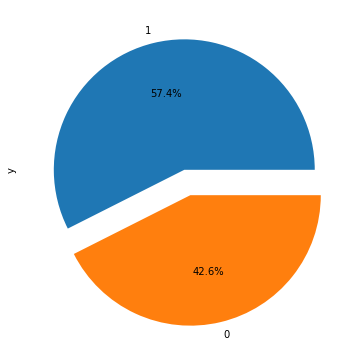

In [36]:
%%time
import matplotlib as plt

df["y"].value_counts().plot(kind = 'pie', 
                                  explode = [0,0.2], 
                                  figsize= (6,6),
                                  autopct='%1.1f%%')


In [37]:
df.drop(columns='Action',inplace=True)
df_mod = df
df_mod.head()

,Source_Port,Destination_Port,NAT_Source_Port,NAT_Destination_Port,Bytes,Bytes_Sent,Bytes_Received,Packets,Elapsed_Time_(sec),pkts_sent,pkts_received,y
0,57222,53,54587,53,177,94,83,2,30,1,1,1
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9,1
2,6881,50321,43265,50321,238,118,120,2,1199,1,1,1
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7,1
4,50002,443,45848,443,25358,6778,18580,31,16,13,18,1


# Create X and Y arrays

In [38]:
%%time
if 'y' in df_mod:
    y = df_mod['y'].values
    del df_mod['y']
    X = df_mod.values

Wall time: 10.9 ms


# Create CV object

In [41]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold

import random
#Setting Seed
#will use this in CV portion
random.seed(10)
seed = random.randint(1,500)
print("seed is:",seed)


#Creating the Task 1 CV
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         random_state = seed,
                         test_size  = 0.2)

print(cv_object)

seed is: 293
ShuffleSplit(n_splits=10, random_state=293, test_size=0.2, train_size=None)


# Baseline SVM 

In [45]:
%%time
from sklearn.svm import SVC
from sklearn import metrics as mt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

std_scl = StandardScaler()

clf = SVC(gamma='auto')


                            
pipeline_object = Pipeline([('scale', std_scl),  
                             ('model',clf)]) 
 
                            
                            
Iteration = []
Accuracy = []
Precision = []
Recall = []

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    pipeline_object.fit(X[train_indices],y[train_indices])  
    y_hat = pipeline_object.predict(X[test_indices]) 
    
    
    
    Iteration.append(iter_num)
    Accuracy.append(mt.accuracy_score(y[test_indices],y_hat))
    Precision.append(mt.precision_score(y[test_indices],y_hat))
    Recall.append(mt.recall_score(y[test_indices],y_hat))
    
SVM_baseline = pd.DataFrame({'Iteration':Iteration,'Accuracy': Accuracy,'Precision':Precision,
                                'Recall':Recall},columns = ['Iteration','Accuracy','Precision','Recall'])


SVM_baseline

Wall time: 1min 28s


,Iteration,Accuracy,Precision,Recall
0,0,0.998169,1.000000,0.996791
1,1,0.997330,0.998932,0.996405
2,2,0.996948,0.998933,0.995744
3,3,0.997406,0.999335,0.996155
4,4,0.997787,0.999606,0.996598
5,5,0.997482,0.999600,0.996018
6,6,0.997482,0.999461,0.996106
7,7,0.998245,0.999733,0.997202
8,8,0.997177,0.999204,0.995902
9,9,0.997482,0.999333,0.996275


# Gridsearch SVM

In [47]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

##model and scale
clf = SVC(gamma='auto')
std_scl = StandardScaler()

parameters = {
    'kernel': ['rbf','sigmoid','linear']
   }


#Gridsearch
grid = GridSearchCV(clf,param_grid=parameters,cv=10,scoring='recall',refit=True,verbose=True,
                   n_jobs=10)


pipeline_object = Pipeline([('standard', std_scl),  
                             ('gridsearch',grid)]) 
 

pipeline_object.fit(X_train,y_train)

print(grid.best_estimator_)
print("------------------------------------------------------------------------")
cv_results = pd.DataFrame(grid.cv_results_)
print(cv_results.iloc[grid.best_index_])
print("------------------------------------------------------------------------")
print(grid.best_params_)


Fitting 10 folds for each of 3 candidates, totalling 30 fits
SVC(gamma='auto', kernel='linear')
------------------------------------------------------------------------
mean_fit_time                     5.64399
std_fit_time                     0.430152
mean_score_time                  0.186134
std_score_time                  0.0630317
param_kernel                       linear
params               {'kernel': 'linear'}
split0_test_score                0.994684
split1_test_score                0.996678
split2_test_score                0.996678
split3_test_score                0.996346
split4_test_score                0.997674
split5_test_score                0.999003
split6_test_score                0.997674
split7_test_score                0.997341
split8_test_score                 0.99568
split9_test_score                 0.99568
mean_test_score                  0.996744
std_test_score                 0.00117757
rank_test_score                         1
Name: 2, dtype: object
----------

# Final SVM

In [49]:
%%time
std_scl = StandardScaler()

clf = SVC(gamma='auto',kernel='linear')


                            
pipeline_object = Pipeline([('scale', std_scl),  
                             ('model',clf)]) 
 
                            
                            
Iteration = []
Accuracy = []
Precision = []
Recall = []

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    pipeline_object.fit(X[train_indices],y[train_indices])  
    y_hat = pipeline_object.predict(X[test_indices]) 
    
    
    
    Iteration.append(iter_num)
    Accuracy.append(mt.accuracy_score(y[test_indices],y_hat))
    Precision.append(mt.precision_score(y[test_indices],y_hat))
    Recall.append(mt.recall_score(y[test_indices],y_hat))
    
SVM_tuned = pd.DataFrame({'Iteration':Iteration,'Accuracy': Accuracy,'Precision':Precision,
                                'Recall':Recall},columns = ['Iteration','Accuracy','Precision','Recall'])


print(SVM_tuned)

Wall time: 25.7 s


,Iteration,Accuracy,Precision,Recall
0,0,0.998245,1.000000,0.996925
1,1,0.997787,0.998933,0.997204
2,2,0.997406,0.998933,0.996542
3,3,0.997711,0.999335,0.996685
4,4,0.997940,0.999606,0.996860
5,5,0.997406,0.999600,0.995885
6,6,0.997864,0.999461,0.996778
7,7,0.998322,0.999733,0.997335
8,8,0.997482,0.999205,0.996431
9,9,0.998093,0.999333,0.997339


# SGD baseline


In [50]:
%%time

from sklearn.linear_model import SGDClassifier

std_scl = StandardScaler()

clf = SGDClassifier(max_iter=1000, tol=1e-3)

                            
pipeline_object = Pipeline([('scale', std_scl),  
                             ('model',clf)]) 
 
                            
                            
Iteration = []
Accuracy = []
Precision = []
Recall = []

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    pipeline_object.fit(X[train_indices],y[train_indices])  
    y_hat = pipeline_object.predict(X[test_indices]) 
    
    
    
    Iteration.append(iter_num)
    Accuracy.append(mt.accuracy_score(y[test_indices],y_hat))
    Precision.append(mt.precision_score(y[test_indices],y_hat))
    Recall.append(mt.recall_score(y[test_indices],y_hat))
    
SGD_baseline = pd.DataFrame({'Iteration':Iteration,'Accuracy': Accuracy,'Precision':Precision,
                                'Recall':Recall},columns = ['Iteration','Accuracy','Precision','Recall'])


SGD_baseline

Wall time: 1.11 s


,Iteration,Accuracy,Precision,Recall
0,0,0.998169,1.000000,0.996791
1,1,0.997864,0.998933,0.997337
2,2,0.997024,0.998933,0.995877
3,3,0.997711,0.999335,0.996685
4,4,0.997635,0.999606,0.996337
5,5,0.997253,0.999600,0.995620
6,6,0.997864,0.999461,0.996778
7,7,0.998398,0.999733,0.997468
8,8,0.997559,0.999205,0.996563
9,9,0.997940,0.999333,0.997073


# SGD gridsearch


In [52]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

##model and scale
clf = SGDClassifier(max_iter=1000, tol=1e-3)
std_scl = StandardScaler()

parameters = {
    'penalty': ['l2','l1','elasticnet'],
    'loss':['hinge','log','modified_huber'],
    
   }


#Gridsearch
grid = GridSearchCV(clf,param_grid=parameters,cv=10,scoring='recall',refit=True,verbose=True,
                   n_jobs=10)


pipeline_object = Pipeline([('standard', std_scl),  
                             ('gridsearch',grid)]) 
 

pipeline_object.fit(X_train,y_train)

print(grid.best_estimator_)
print("------------------------------------------------------------------------")
cv_results = pd.DataFrame(grid.cv_results_)
print(cv_results.iloc[grid.best_index_])
print("------------------------------------------------------------------------")
print(grid.best_params_)


Fitting 10 folds for each of 9 candidates, totalling 90 fits
SGDClassifier(loss='modified_huber', penalty='l1')
------------------------------------------------------------------------
mean_fit_time                                           0.308249
std_fit_time                                           0.0929722
mean_score_time                                       0.00279183
std_score_time                                       0.000598415
param_loss                                        modified_huber
param_penalty                                                 l1
params               {'loss': 'modified_huber', 'penalty': 'l1'}
split0_test_score                                       0.997012
split1_test_score                                       0.997676
split2_test_score                                        0.99834
split3_test_score                                       0.998341
split4_test_score                                       0.997345
split5_test_score                  

# Final SGD

In [53]:
%%time
std_scl = StandardScaler()

clf = SGDClassifier(max_iter=1000, tol=1e-3,loss='modified_huber',penalty='l1')

                            
pipeline_object = Pipeline([('scale', std_scl),  
                             ('model',clf)]) 
 
                            
                            
Iteration = []
Accuracy = []
Precision = []
Recall = []

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    pipeline_object.fit(X[train_indices],y[train_indices])  
    y_hat = pipeline_object.predict(X[test_indices]) 
    
    
    
    Iteration.append(iter_num)
    Accuracy.append(mt.accuracy_score(y[test_indices],y_hat))
    Precision.append(mt.precision_score(y[test_indices],y_hat))
    Recall.append(mt.recall_score(y[test_indices],y_hat))
    
SGD_final = pd.DataFrame({'Iteration':Iteration,'Accuracy': Accuracy,'Precision':Precision,
                                'Recall':Recall},columns = ['Iteration','Accuracy','Precision','Recall'])


SGD_final

,Iteration,Accuracy,Precision,Recall
0,0,0.998932,1.000000,0.998128
1,1,0.998169,0.998934,0.997870
2,2,0.998398,0.997215,1.000000
3,3,0.997940,0.999468,0.996950
4,4,0.998550,0.999607,0.997907
5,5,0.998169,0.999601,0.997213
6,6,0.998550,0.999462,0.997986
7,7,0.998703,0.999733,0.998001
8,8,0.997864,0.999337,0.996960
9,9,0.998245,0.999334,0.997605


# SVM ROC curve

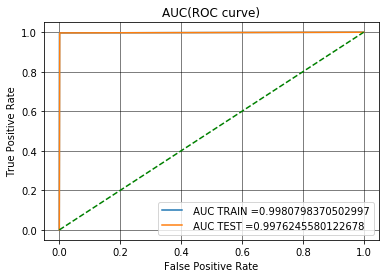

Wall time: 3.55 s


In [54]:
%%time
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)



clf = SVC(gamma='auto',kernel='linear')




piped_object = Pipeline([('scale', std_scl),  
                         ('model', clf)]) 




piped_object.fit(X_train,y_train)

y_train_pred =piped_object.predict(X_train)    
y_test_pred = piped_object.predict(X_test) 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

# SGD ROC

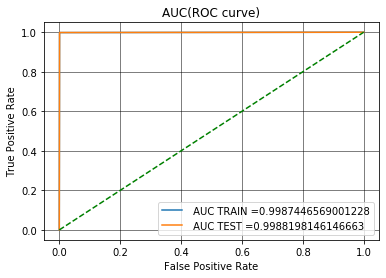

Wall time: 367 ms


In [55]:
%%time
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)



clf =  SGDClassifier(max_iter=1000, tol=1e-3,loss='modified_huber',penalty='l1')




piped_object = Pipeline([('scale', std_scl),  
                         ('model', clf)]) 




piped_object.fit(X_train,y_train)

y_train_pred =piped_object.predict(X_train)    
y_test_pred = piped_object.predict(X_test) 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()